<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Wiener_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The non-causal Wiener filter, which estimates $X$ from $Y$ by $\hat{X} = h * Y$ is given by 

$$h * R_Y = R_{XY}$$

with $R_Y$ and $R_{XY}$ being the autocorrelation and cross-correlation respectively. Thus $h$ is the stable filter with z-Transform

$$H(z) = \frac{S_{XY} (z)}{S_Y(z)}$$

Examine the situation on page 140 in the lecture notes (as of 2020). $X$ is filtered by $h$ to produce $Z$ which is transmitted over some channel with added noise $W$. We now wish to use a filter $g$ to produce the best LMMSE estimate $\hat{X}$ of $X$.

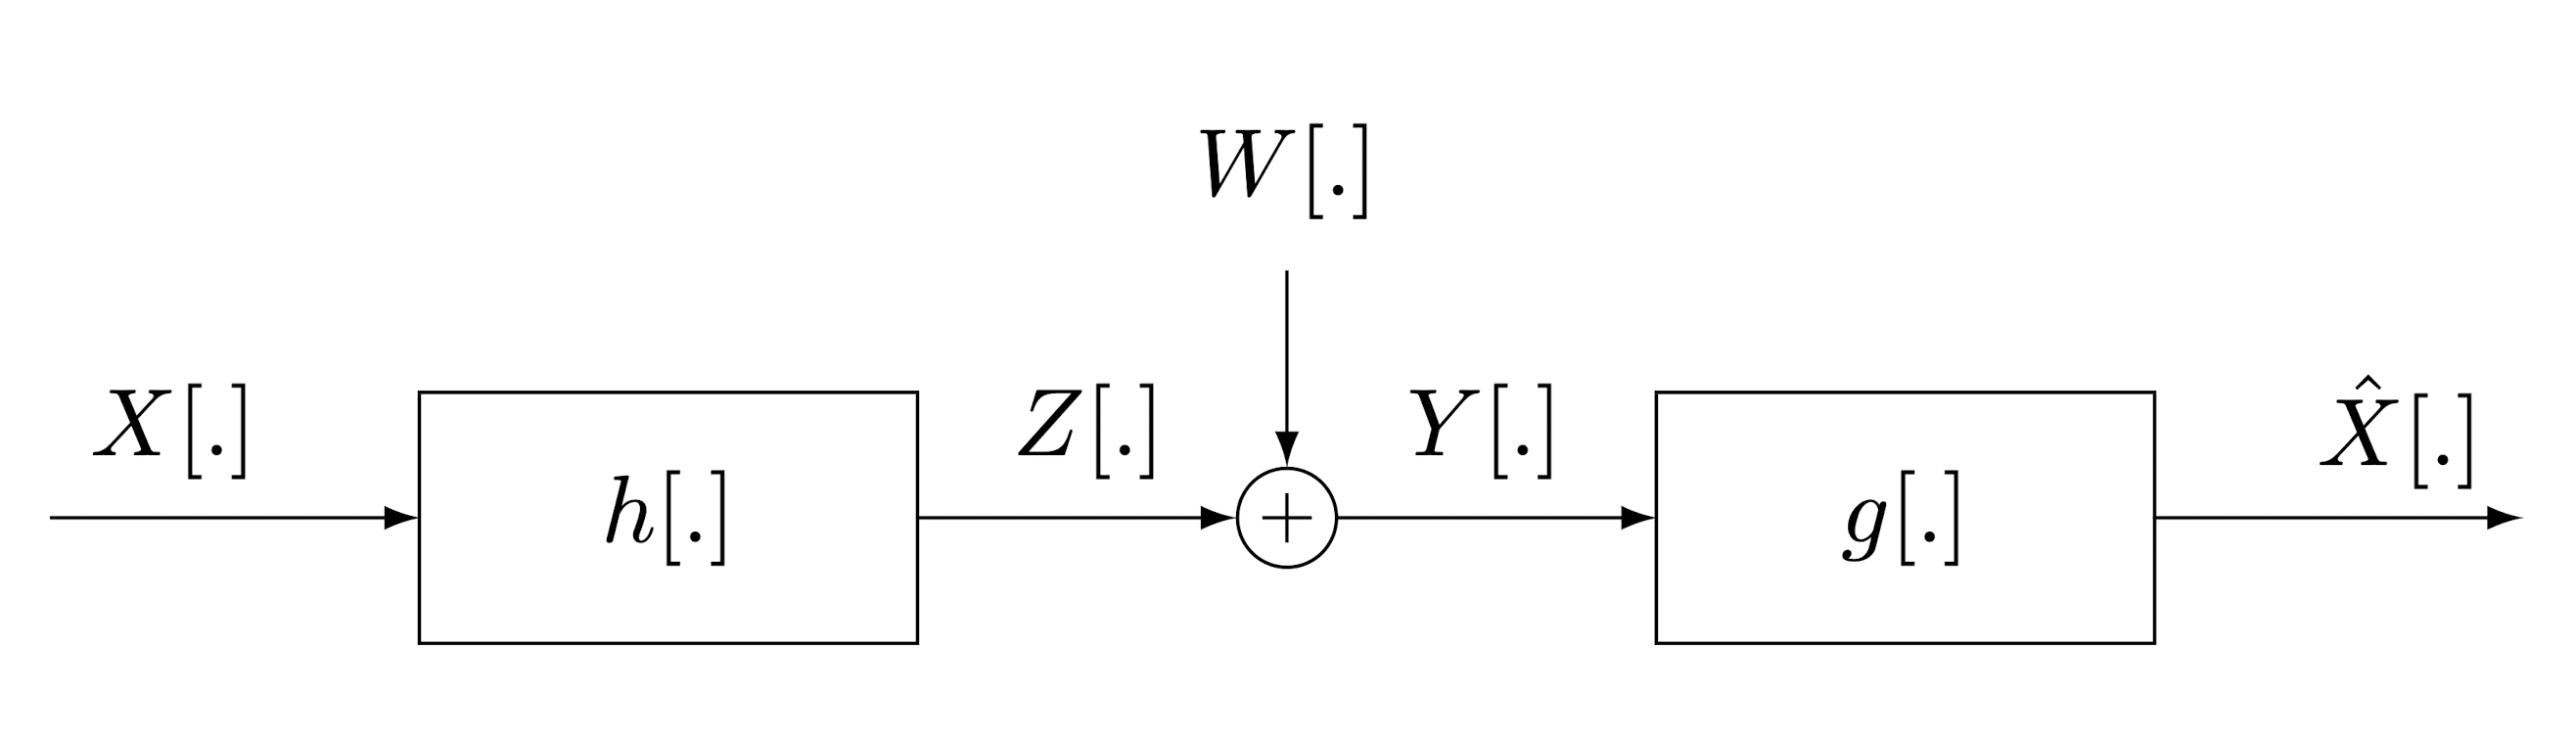

Assuming $X$ and $W$ are independent and centered (zero mean) stochastic processes we obtain
$$R_{XY} = R_{XZ} \qquad S_{XY} = S_{XZ} \qquad R_Y = R_Z + R_W \qquad S_Y = S_Z + S_W$$

Therefore we get for the noncausal Wiener filter

$$G(z) = \frac{S_{XZ}(z)}{S_Z(z) + S_W(z)} = \frac{S_X (z) H^c (z)}{S_X(z) H (z) H^c(z) + S_W(z)}$$

We notice that $G(z) H(z) = \frac{S_Z(z)}{S_Z(z) + S_W(z)}$, i.e. in this case the Wiener filter coincides with robust inversion, albeit with $\sigma$ not freely selectable.

In the following example you will get to choose different signals $X$ as input as well as different filters $h$. The channel noise $W$ is assumed to be white noise with power $\sigma^2$, i.e. $S_W(z) = \sigma^2$. Since a priori we have no information which signals are transmitted $X$ is also modelled as white noise. For this task we may assume that $X$ has power spectral density $1$ over all frequencies, i.e. $S_X(z) = 1$.

In [41]:
pip install pydsm

In [42]:
!gdown https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
!gdown https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt

Downloading...
From: https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
To: /content/signals.py
100% 5.55k/5.55k [00:00<00:00, 8.52MB/s]
Downloading...
From: https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt
To: /content/filters.py
100% 1.90k/1.90k [00:00<00:00, 1.47MB/s]


In [47]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydsm.ft import idtft
import signals
import filters
#-------------------------------------------------------------------------------

sigmaG = 1

logPlotG = False

#Important Stuff
################################################################################

#filter h
def h(t):
  return np.real(idtft(filters.H, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#robust inversion filter G
def G(Omega):
  return np.conjugate(filters.H(Omega))/(np.abs(filters.H(Omega))**2 + sigmaG**2)

#filter g
def g(t):
  return np.real(idtft(G, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#noise
def w(t):
  return np.random.normal(0,0.05,1)[0]

#received signal
def y():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  u_ = signals.time_domain_signal_long()
  h_ = [h(t) for t in signals.nG]
  w_ = [w(t) for t in np.arange(4*signals.nG.size-1)] #result of convolution has dimension (N+M-1) i.e. (nG.size+nG.size-1) = 2*nG.size-1
  r_ = np.convolve(u_,h_) + w_
  delta = len(r_) - len(u_)
  return r_[delta//2: -delta//2]

#estimation
def u_hat():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  y_ = y()
  g_ = [g(t) for t in signals.nG]
  r_ = np.convolve(y_, g_)
  delta = len(r_) - len(y_)
  return r_[delta//2: -delta//2]
################################################################################

#drawing plots
def plot():
  Omega_values = np.linspace(-np.pi, np.pi, 200)
  H_values = [filters.H(Omega) for Omega in Omega_values]
  G_values = [G(Omega) for Omega in Omega_values]

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_xlabel('$\Omega$', fontsize=14)
  ax1.set_ylabel('$H(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax1.plot(Omega_values, H_values, alpha=0.5);
  else:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax1.semilogy(Omega_values, H_values, alpha=0.5);

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_xlabel('$\Omega$', fontsize=14)
  ax2.set_ylabel('$G(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax2.plot(Omega_values, G_values, alpha=0.5);
  else:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax2.semilogy(Omega_values, G_values, alpha=0.5);

def plot_time():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_values = signals.time_domain_signal_long()
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  y_values = y()
  t3_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_hat_values = u_hat()


  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$u(k)$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  if logPlotG == False:
    ax1.axis(ymin=-3, ymax=3)
    ax1.plot(t1_values, u_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax1.axis(ymin=0.1, ymax=3)
    ax1.semilogy(t1_values, u_values, alpha=0.5, marker='o', markersize=8);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y(k)$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  if logPlotG == False:
    ax2.axis(ymin=-3, ymax=3)
    ax2.plot(t2_values, y_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax2.axis(ymin=0.1, ymax=3)
    ax2.semilogy(t2_values, y_values, alpha=0.5, marker='o', markersize=8);

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.grid()
  ax3.set_xlabel('$k$', fontsize=14)
  ax3.set_ylabel('$\hat{u}(k)$', fontsize=14)
  ax3.axis(xmin=t3_values[0], xmax=t3_values[-1])
  if logPlotG == False:
    ax3.axis(ymin=-3, ymax=3)
    ax3.plot(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax3.axis(ymin=0.1, ymax=3)
    ax3.semilogy(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);

In [44]:
signals.widget()
filters.widget()

def update_parameters(sigma, logPlot):
  global sigmaG, logPlotG
  sigmaG, logPlotG = sigma, logPlot

widgets.interact(update_parameters,
  sigma = widgets.FloatSlider(
    value=1,
    min=0.01,
    max=10,
    description='sigma'),
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);

interactive(children=(Dropdown(description='signal type', options=('unit step', 'unit impulse', 'ramp', 'expon…

interactive(children=(Dropdown(description='filter type', options=('low pass', 'high pass', 'band pass', 'all …

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0, min=0.01), Checkbox(value=False, d…

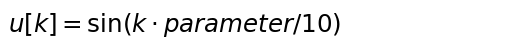

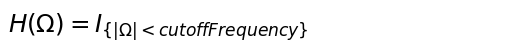

In [50]:
signals.display_signal_selection(continuous=False)
filters.display_filter_selection(continuous=False)

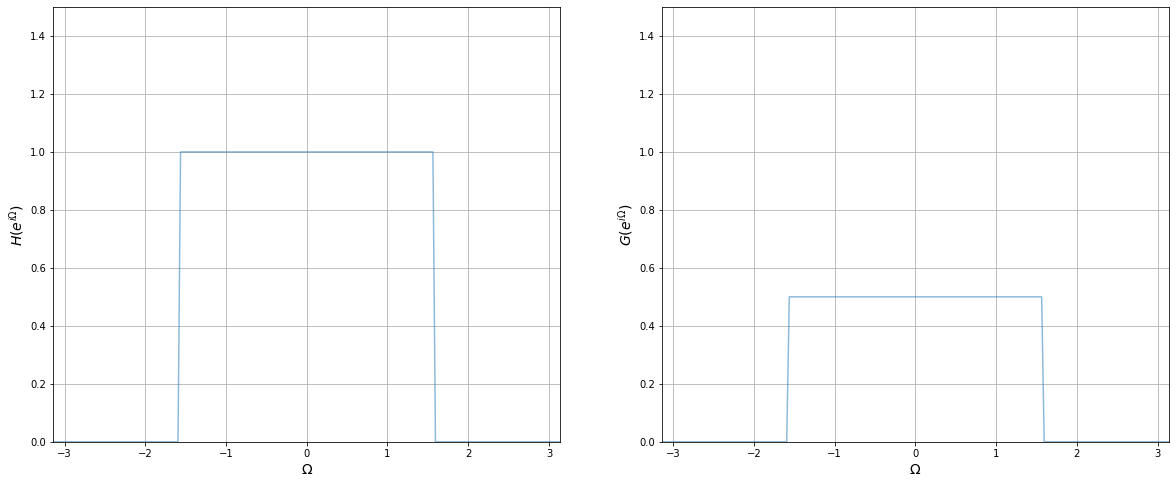

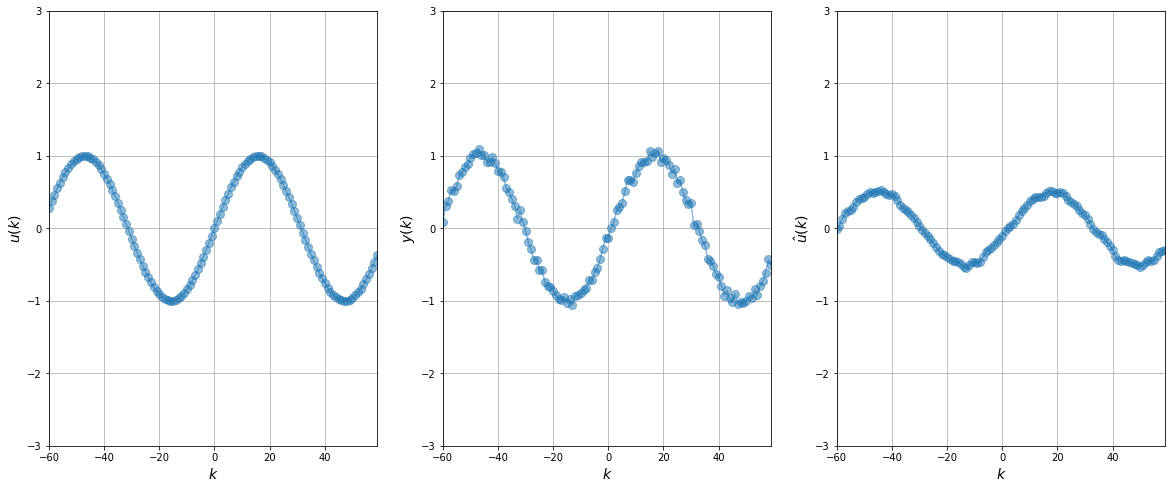

In [49]:
plot()
plot_time()